## Les librairies


In [2]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import regularizers
from PIL import Image
from keras.utils import to_categorical
import cv2
import numpy as np
import joblib
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from livelossplot import PlotLossesKeras
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Input, Lambda, Dense, Flatten
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

## Les fonctions

In [3]:
## Prétraitement de l'image : redimensionnemennt et standardization 
def preprocess_img(img,new_dim=(240,320)):
    new_img=cv2.resize(img, (new_dim[1],new_dim[0]), interpolation = cv2.INTER_AREA)
    mean = np.mean(new_img)
    std = np.std(new_img)
    new_img=(new_img-mean)/std
    return new_img

## Récupération des images et préparation de la dataset

In [3]:
# Chemin vers le dossier principal contenant les sous-dossiers
main_folder = '../../data/'
img_dim=(240,320,3)

In [4]:
X=[]
Y=[]


for target_folder in os.listdir(main_folder):
    target_path = os.path.join(main_folder, target_folder)
    
    if os.path.isdir(target_path):
        for side in ['left']:#, 'right']:
            side_path = os.path.join(target_path, side)
            if os.path.isdir(side_path):
                for image_filename in os.listdir(side_path):
                    if image_filename.lower().endswith(('.bmp', '.jpg', '.png')):
                        image_path = os.path.join(side_path, image_filename)
                        target =int(target_folder)
                        image = preprocess_img(cv2.imread(image_path),img_dim)
                        X.append(image)
                        Y.append(target)
                                        
                        

In [7]:
!pwd

/d/Documents/Ecole/Rendus_Ecole_Simplon/PCO/reconnaissance_iris/code/notebooks/original


In [4]:
# Chargement des variables en local
X = joblib.load(r"../../variables/oeil_gauche/X")
Y = joblib.load(r"../../variables/oeil_gauche/y")

In [5]:
labelEnc=preprocessing.LabelEncoder()
Y_enc=labelEnc.fit_transform(Y)

In [6]:
# Split the data into training and testing sets while maintaining class distribution
X_train, X_test, y_train, y_test = train_test_split(X, Y_enc, test_size=0.2, random_state=42, stratify=Y_enc)

y_train_enc=to_categorical(y_train)
y_test_enc=to_categorical(y_test)

In [7]:
X_train

array([[[[168, 176, 168],
         [176, 176, 176],
         [176, 176, 176],
         ...,
         [128, 132, 128],
         [136, 140, 136],
         [136, 132, 136]],

        [[176, 180, 176],
         [168, 176, 176],
         [176, 176, 168],
         ...,
         [128, 136, 136],
         [136, 136, 136],
         [128, 128, 128]],

        [[176, 184, 176],
         [176, 176, 176],
         [176, 180, 176],
         ...,
         [136, 136, 136],
         [136, 136, 136],
         [136, 140, 136]],

        ...,

        [[168, 172, 168],
         [160, 164, 160],
         [160, 164, 160],
         ...,
         [152, 152, 152],
         [144, 148, 144],
         [152, 148, 152]],

        [[224, 228, 224],
         [208, 212, 208],
         [208, 216, 216],
         ...,
         [192, 200, 200],
         [200, 200, 200],
         [192, 196, 192]],

        [[  0,   4,   0],
         [  8,   8,   8],
         [  0,   4,   0],
         ...,
         [  0,   8,   0],
        

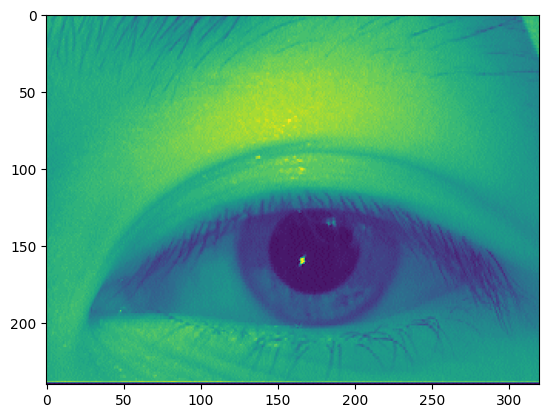

In [9]:
plt.imshow(X_train[0][:,:,2])

## Entrainement du modèle et affichage des performances

In [8]:
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
early = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [9]:
NBCLASSES = 45
IMSIZE=[240,320]
def create_model():
    vgg = VGG16(input_shape=IMSIZE + [3], weights='imagenet', include_top=False)
 
    # Freeze existing VGG already trained weights 

    for layer in vgg.layers:
        layer.trainable = False
     
    # get the VGG output
    out = vgg.output
     
    # Add new dense layer at the end
    x = Flatten()(out)
    x = Dense(NBCLASSES, activation='softmax')(x)
     
    model = Model(inputs=vgg.input, outputs=x)
     
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])
     
    model.summary()
     
    return model
 
OG_model = create_model()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 320, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 160, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 160, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 160, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 80, 128)       0  

In [10]:
hist = OG_model.fit(np.array(X_train), np.array(y_train_enc), batch_size = 30, epochs = 50, validation_split=0.25,callbacks=[rlrop,early,PlotLossesKeras()])

Epoch 1/50


5/5 [==============================] - ETA: 0s - loss: 68.8041 - accuracy: 0.1111

In [15]:
# Exemple de données de test (remplacez cela par vos propres données)

y_test_pred = [np.argmax(v) for v in OG_model.predict(np.array(X_test))]  # Prédictions du modèle


2/2 [==============================] - 3s 838ms/step


Matrice de confusion :
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
Précision : 0.87
Rappel : 0.91
Score F1 : 0.88
Exactitude : 0.91


d:\Documents\Ecole\Rendus_Ecole_Simplon\PCO\reconnaissance_iris\code\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


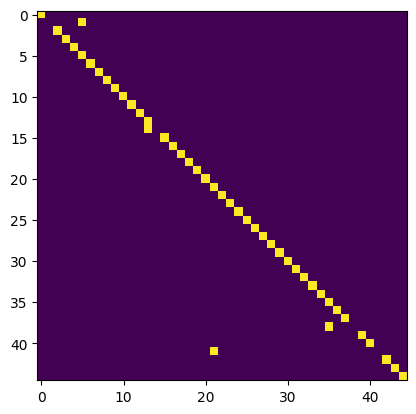

In [16]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(np.array(y_test), np.array(y_test_pred))

# # Calcul des mesures de performance
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred,average='macro')
recall = recall_score(y_test, y_test_pred,average='macro')
f1 = f1_score(y_test, y_test_pred,average='macro')

print("Matrice de confusion :")
plt.imshow(conf_matrix)
print(conf_matrix)
print("Précision : {:.2f}".format(precision))
print("Rappel : {:.2f}".format(recall))
print("Score F1 : {:.2f}".format(f1))
print("Exactitude : {:.2f}".format(accuracy))

In [20]:
OG_model.save("vgg16_side_OG2ID_classif")

INFO:tensorflow:Assets written to: vgg16_side_OG2ID_classif\assets


INFO:tensorflow:Assets written to: vgg16_side_OG2ID_classif\assets
